# How to calculate the effect of different factors on direct greenhouse gas emissions in Norway using LMDI-IDA based methods (aka why are emissions so stagnant...)

Author: Benedikt Goodman 

Email: goodmanbenedikt@gmail.com

We've had over 30 years of different climate policies in Norway, but despite gunning for a significant reductions emissions were only 4% lower than the reference year (1990) in 2020. Meanwhile Sweden has almost cut their emissions in half. So what happened?
This question was one of the things I wanted to focus on in my masters' thesis which I completed during the spring of 2022.

Of course I had to narrow it down so I ended up narrowing it down to identifying a set of drivers of emissions, then measuring the effect of these over time. This is done via something called index decomposition analysis (IDA) and you can read more about it [here](https://www.tandfonline.com/doi/full/10.1080/09535314.2019.1652571) and in [my thesis](https://nmbu.brage.unit.no/nmbu-xmlui/handle/11250/3033120) (should you be so inclined). The TLDR of what these methods do is that *they allow us to measure the impact a given set of factors have on something*. In my case I wanted to see what effect a set of drivers had on Norwegian GHG emissions. Much can be said about choice of drivers or if there is a causal link between the drivers and the measured variable in an index analysis (again, see my thesis for a lengthy discussion on that). Anyway, I chose 
the following drivers:

- Economic activity (total GDP)
- Economic structure (industry GDP/Total GDP)
- Energy efficiency (industry consumption of energy/industry GDP)
- Fossil share of energy (fossil energy per industry/industry consumption of energy)
- Carbon efficiency of fossil energy (emissions/fossil energy per industry)

The aggregate result of the analysis can be seen below. There was a net increase in emissions of 6218 mktCO2e (thats 6218 million tonnes), which corresponds to nearly 10% between 1990 and 2019. This is due to the carbon increasing effects from economic growth and worsening energy efficiency outweighing the abating effects structural shifts, lower fossil share and higher carbon efficiency of energy.

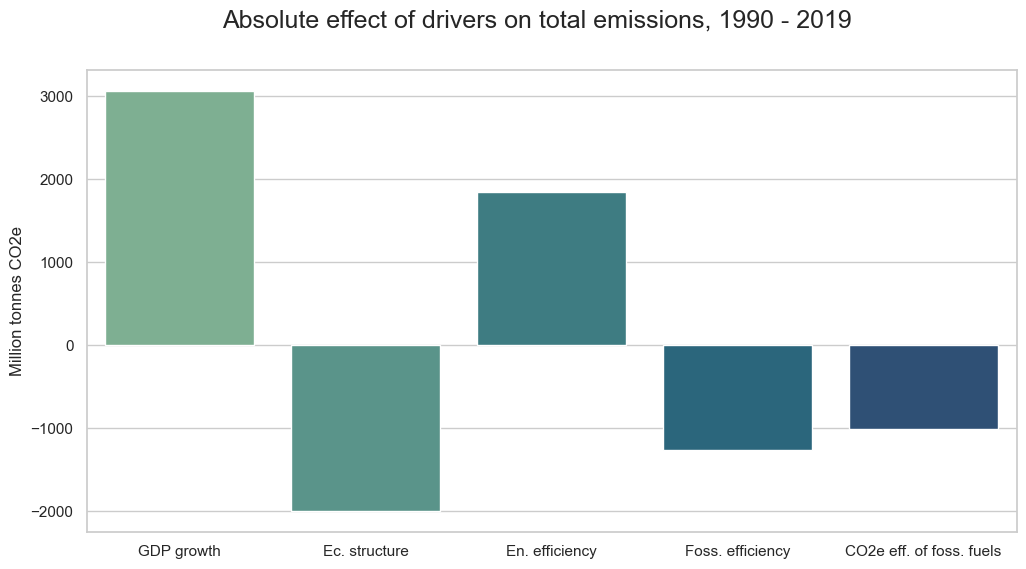 

The results should be seen as a ballpark estimate as there is uncertainty in the underlying data (but they're the best we have). Note that these are *direct emissions* and do not factor in emissions embodied in consumption.  


## A quick look at industry results

A quick look at the results per sector reveals that the main culprits for increasing emissions are (surprise, surprise) the petroleum and transport industries.

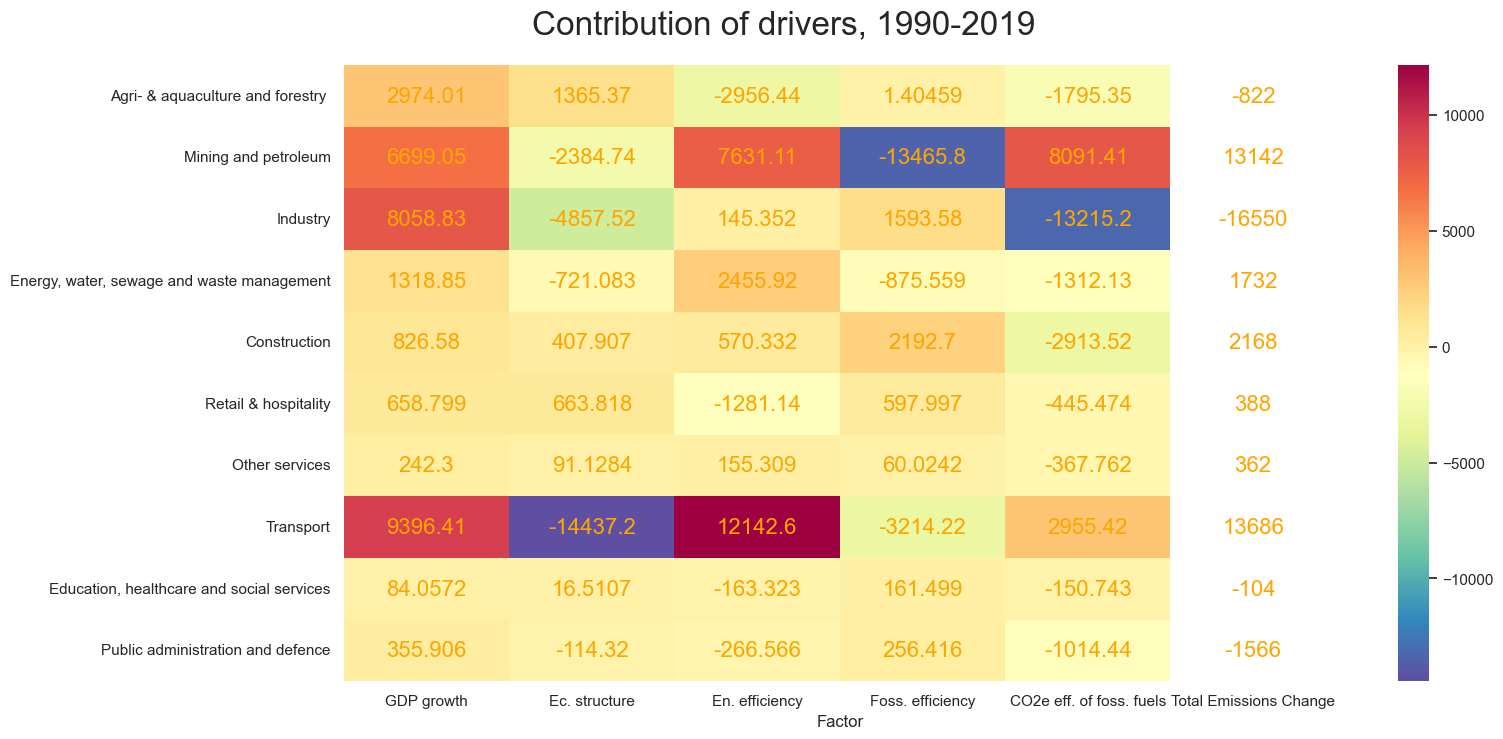

Now then, having said what this is all about I can finally start to explain how this is done in Python. As you will see this analysis is made entirely with pandas, numpy and seaborn. I won't be showing the dataset building. If that's of interest to you, drop me an email at goodmanbenedikt@gmail.com and i can share the whole thing.

Anyway let's get started.



#  Import of data and analysis

In [9]:
# Importing necessary modules
import pandas as pd
import matplotlib.pyplot as plt

# Importing custom functions and classes
from src.df_funcs import (
    identity_assurance_func,
    nested_dict_to_df,
    df_to_nested_dict,
    result_sum_func,
)
from src.lmdi_module import LMDI_analysis
from src.plot_funcs import (
    barplot_additive_aggregate,
    heatmapper_func,
    barplot_additive_drivers,
)

# Import of data and analysis
df = pd.read_csv("data/sektor_kaya.csv")

# Constants for our analysis
factors = ["totGDP", "secGDP/totGDP", "GWh/gdp", "fossGWh/totGWh", "mtCO2e/fossGWh"]
emissions_col = "mtCO2e"
year_col = "år"

# Display variables in raw data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   agg_næring      300 non-null    object 
 1   år              300 non-null    int64  
 2   totGDP          300 non-null    float64
 3   secGDP/totGDP   300 non-null    float64
 4   GWh/gdp         300 non-null    float64
 5   fossGWh/totGWh  300 non-null    float64
 6   mtCO2e/fossGWh  300 non-null    float64
 7   mtCO2e          300 non-null    float64
 8   res             300 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 21.2+ KB


In [10]:
# Apply identity assurance function
df = df.pipe(identity_assurance_func, factors, emissions_col)

# Make nested dict of dataframes with næring as key
dfd_agg = df_to_nested_dict(df, "agg_næring")

print("Sectors present in nested dictionary:")
print(dfd_agg.keys())

print()
print("A look inside one of the dataframes within dfd_agg:")
dfd_agg["Industri"].head()

Sectors present in nested dictionary:
dict_keys(['Jordbruk, skogbruk og fiske', 'Bergverksdrift og utvinning av råolje og naturgass, inkl. tjenester', 'Industri', 'Energi- og vannforsyning, avløp og renovasjon', 'Bygge- og anleggsvirksomhet', 'Varehandel, rep. av motorvogner, overnatting og servering', 'Andre tjenesteytende næringer', 'Transport', 'Undervisning, helse- og sosialtjenester', 'Offentlig administrasjon og forsvar'])

A look inside one of the dataframes within dfd_agg:


,agg_næring,år,totGDP,secGDP/totGDP,GWh/gdp,fossGWh/totGWh,mtCO2e/fossGWh,mtCO2e,res
60,Industri,1990,1776729.0,0.098590,1.480907,2.209640,0.035224,20190.0,0.0
61,Industri,1991,1781787.0,0.096202,1.441839,2.229285,0.033668,18550.0,0.0
62,Industri,1992,1833320.0,0.094748,1.536916,2.227178,0.027503,16353.0,0.0
63,Industri,1993,1857118.0,0.094312,1.540863,2.239800,0.028449,17197.0,0.0
64,Industri,1994,1961089.0,0.090635,1.580675,2.248752,0.028661,18108.0,0.0


## How the LMDI-IDA analysis works

The logarithmic mean divisa index is not very diffiult to make, but when I started out I was very happy to learn that some researchers had already made some of the source code and put them on [Github](https://github.com/xiwang2718/PyLMDI) (i don't know who you are xiwang2718, but I owe you).

First of all you need to arrange your factors (i.e. your data) as an identity ([like the KAYA identity](https://en.wikipedia.org/wiki/Kaya_identity)) like so:

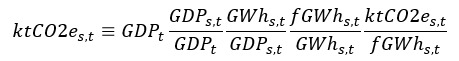

Then for any given factor the effect is measured as follows:

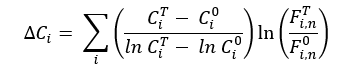

Where 𝑖 indicates sector, 𝐶 is emissions, 𝐹 is factor and 𝑛 is factor number and the
superscripts 𝑇 and 0 indicate time. Results will be in the number of units the individual factor
adds or removes from the contributor from period to period.

If the change between time periods is 0 then the two fractions will be set to 0 and 1 respectively. This prevents the model from misbehaving. Note that it is still sensitive to negative numbers (but GDP, emissions and energy usage are positive in this dataset).

I've encapsulated the necessary data transformations and calculations into classes in the `lmdi_module`. The `LMDI_analysis` class is what is used to carry out the decomposition.

In [15]:
# Make dict to store results in
res_agg_add = {}
col_list = [year_col] + factors + [emissions_col]

# Run analysis
for industry in dfd_agg.keys():
    res_agg_add[industry] = dfd_agg[industry][col_list].copy()
    res_agg_add[industry] = LMDI_analysis(
        res_agg_add[industry], 1990, 2019, "add", factors, year_col, emissions_col
    ).LMDI_analysis_func()


# Show LMDI-IDA results for the industry
print(res_agg_add["Industri"].head())

# Getting aggregate sums per sector
sum_add = result_sum_func(res_agg_add)

print("A look inside one of the aggregate result dataframes")
print(sum_add["Industri"].head())


          totGDP  secGDP/totGDP      GWh/gdp  fossGWh/totGWh  mtCO2e/fossGWh
1990   55.031351    -474.637239  -517.556690      171.339440     -874.176862
1991  496.914734    -265.417073  1112.961760      -16.477893    -3524.981528
1992  216.306441     -77.365178    43.006530       94.781194      567.271012
1993  961.390722    -701.826753   450.213345       70.400192      130.822493
1994  513.733778    -949.864691  -466.716239      285.532282       -2.685129
A look inside one of the aggregate result dataframes
factor      GWh/gdp  fossGWh/totGWh  mtCO2e/fossGWh  secGDP/totGDP     totGDP
sector                                                                       
Industri  145.35179      1593.57798   -13215.236844   -4857.519326  8058.8264


In [16]:
# Getting aggregate sums per sector
sum_add = result_sum_func(res_agg_add)

print("A look inside one of the aggregate result dataframes")
print(sum_add["Industri"].head())

# Take additive results, turn from nested dict to dataframe
result_add = nested_dict_to_df(sum_add)

print()
print("A look inside a dataframe with results:")
result_add

A look inside one of the aggregate result dataframes
factor      GWh/gdp  fossGWh/totGWh  mtCO2e/fossGWh  secGDP/totGDP     totGDP
sector                                                                       
Industri  145.35179      1593.57798   -13215.236844   -4857.519326  8058.8264

A look inside a dataframe with results:


factor,GWh/gdp,fossGWh/totGWh,mtCO2e/fossGWh,secGDP/totGDP,totGDP
sector,,,,,
"Jordbruk, skogbruk og fiske",-2956.443009,1.404590,-1795.348912,1365.374352,2974.012979
"Bergverksdrift og utvinning av råolje og naturgass, inkl. tjenester",7631.106887,-13465.822975,8091.407288,-2384.740723,6699.049522
Industri,145.351790,1593.577980,-13215.236844,-4857.519326,8058.826400
"Energi- og vannforsyning, avløp og renovasjon",2455.919123,-875.558850,-1312.130576,-721.083056,1318.853359
Bygge- og anleggsvirksomhet,570.331769,2192.698522,-2913.517196,407.907387,826.579518
"Varehandel, rep. av motorvogner, overnatting og servering",-1281.140157,597.996735,-445.474075,663.818411,658.799085
Andre tjenesteytende næringer,155.309292,60.024236,-367.761554,91.128389,242.299638
Transport,12142.576087,-3214.220124,2955.422903,-14437.188284,9396.409417
"Undervisning, helse- og sosialtjenester",-163.323256,161.498901,-150.743500,16.510697,84.057157


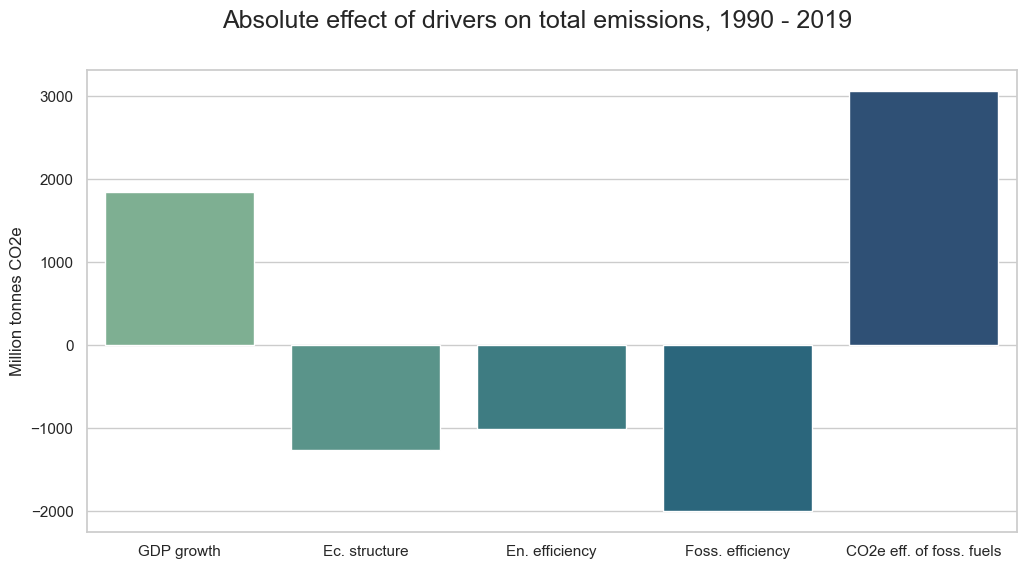

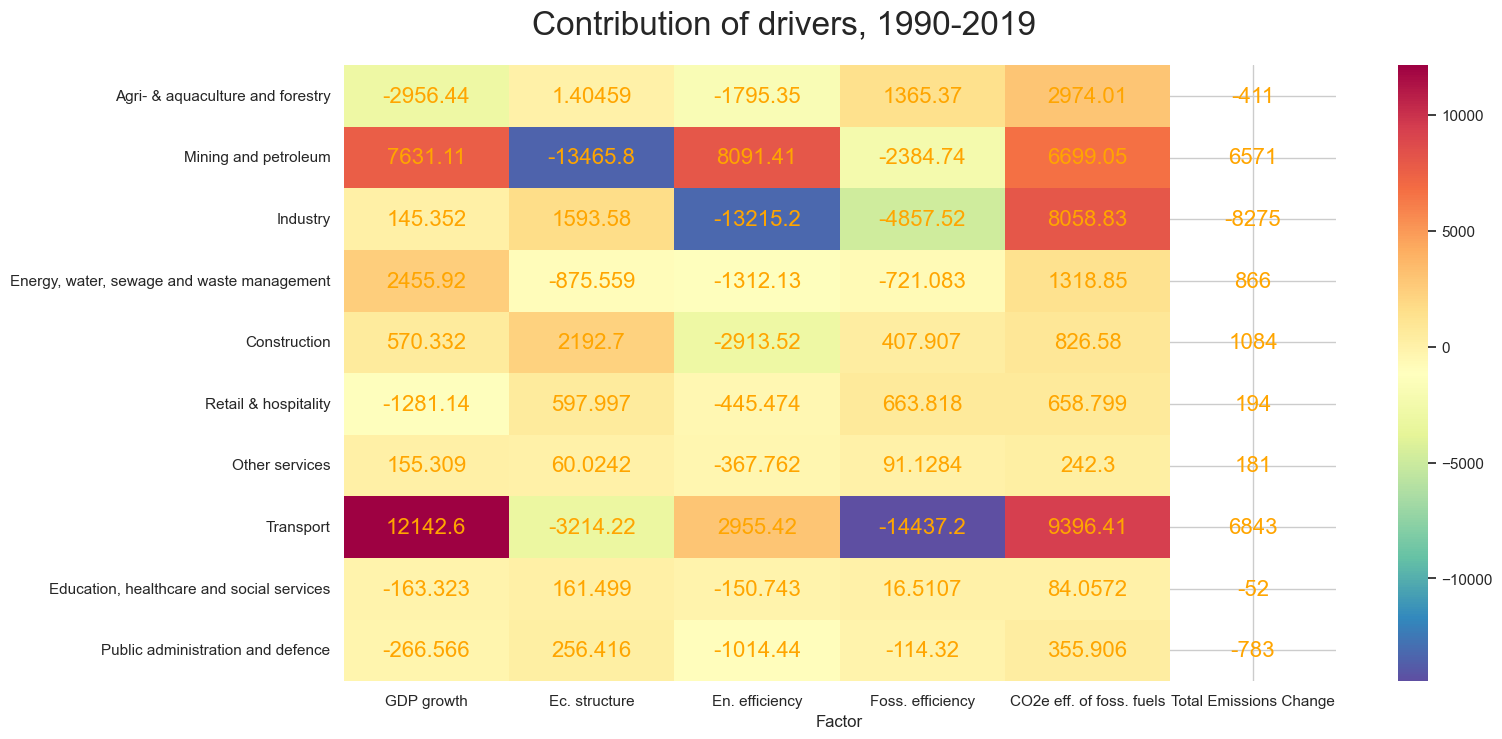

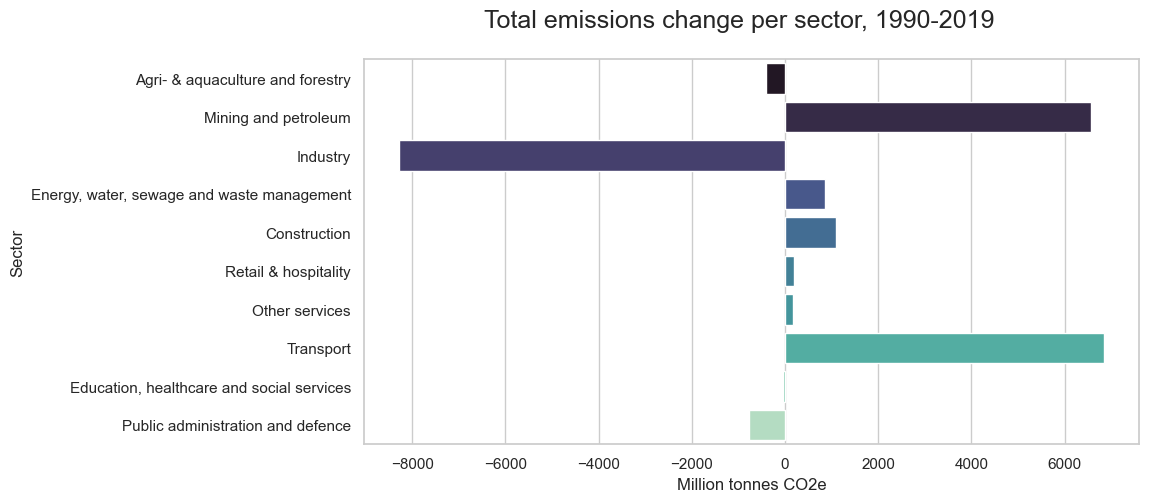

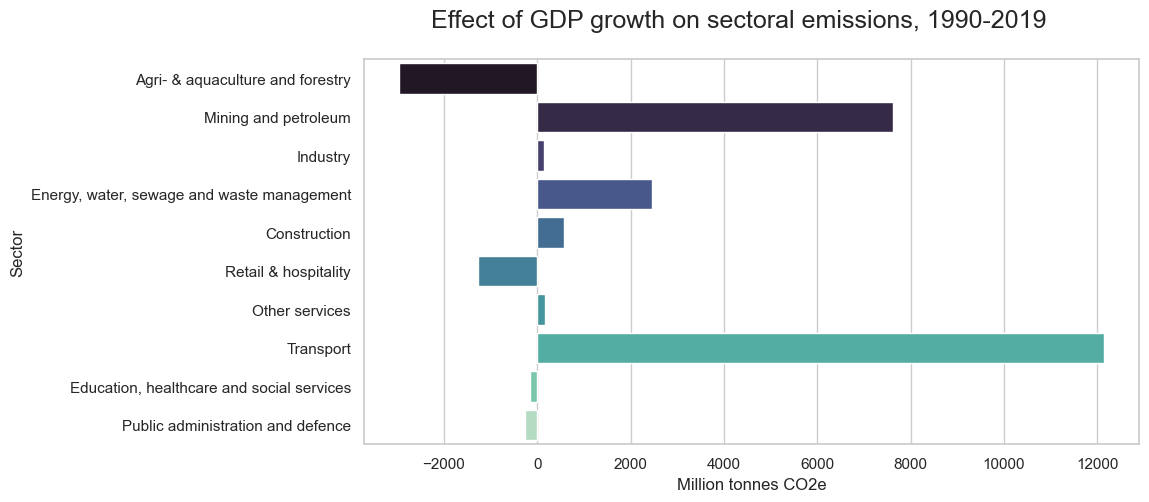

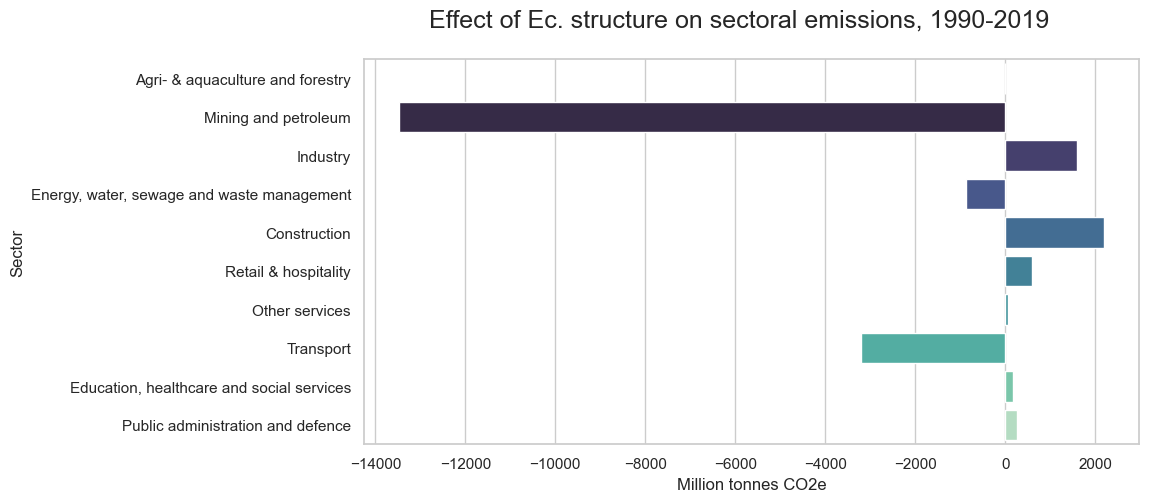

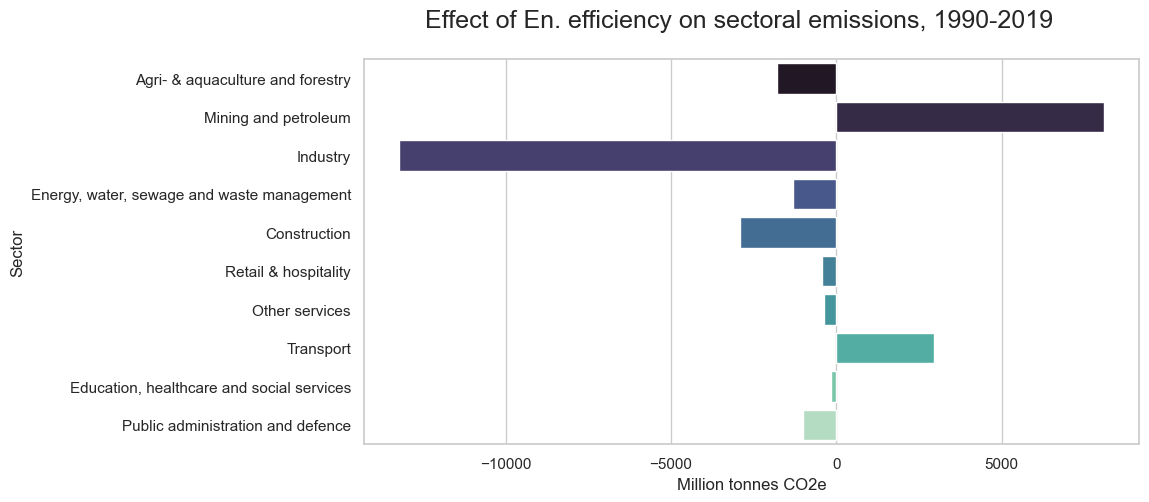

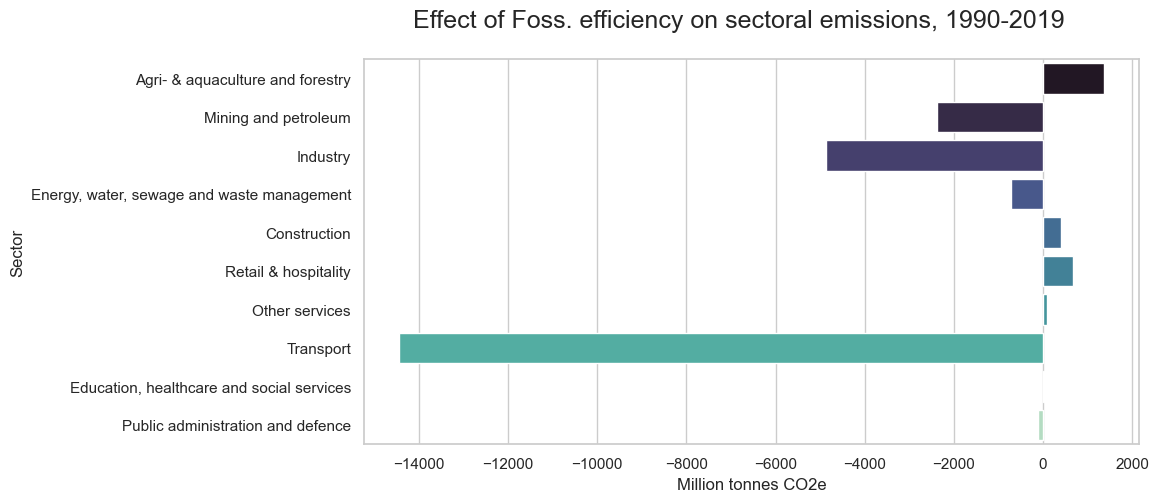

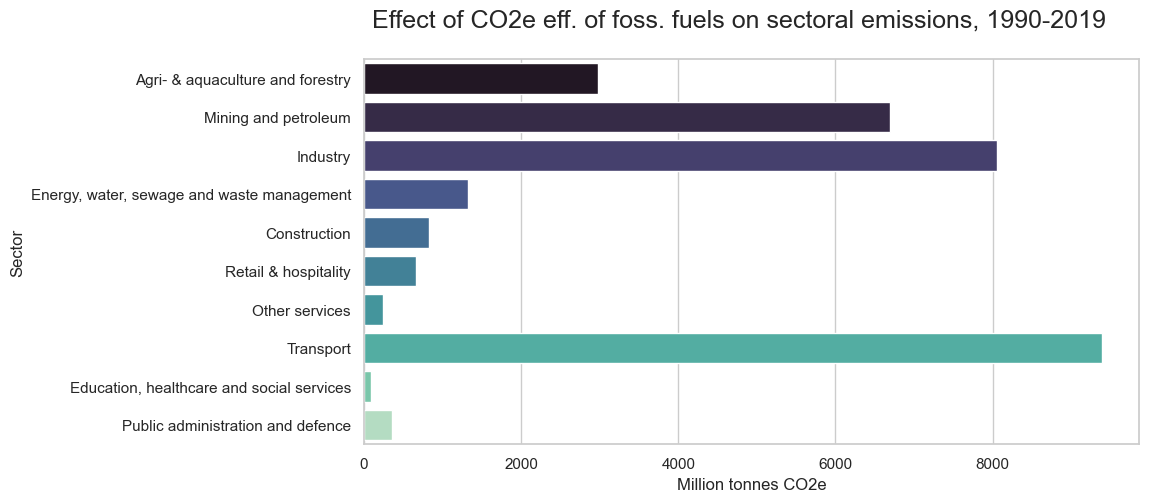

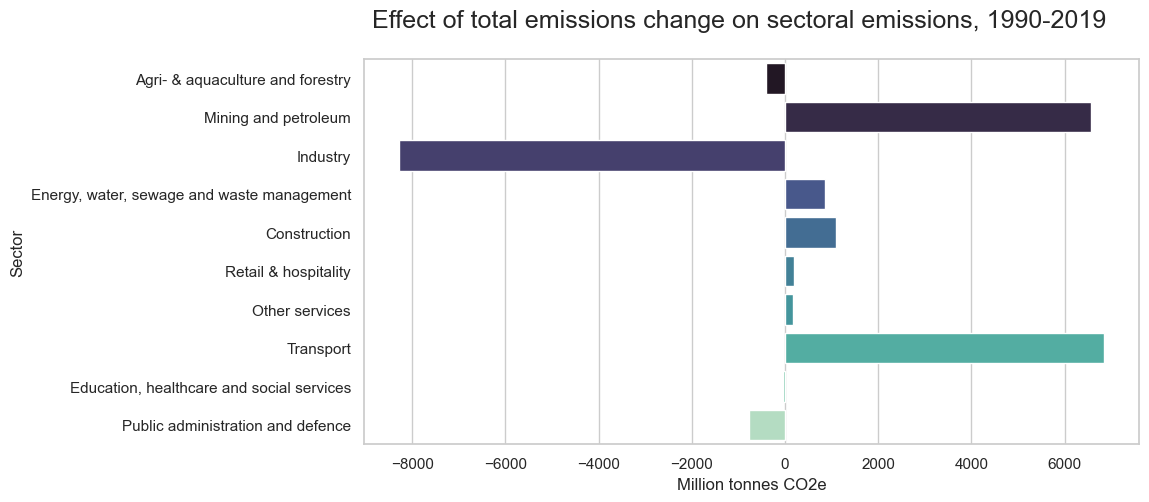

In [5]:
# Plotting of results
factors = [
    "GDP growth",
    "Ec. structure",
    "En. efficiency",
    "Foss. efficiency",
    "CO2e eff. of foss. fuels",
    "Total Emissions Change",
]
sectors = [
    "Agri- & aquaculture and forestry",
    "Mining and petroleum",
    "Industry",
    "Energy, water, sewage and waste management",
    "Construction",
    "Retail & hospitality",
    "Other services",
    "Transport",
    "Education, healthcare and social services",
    "Public administration and defence",
]

result_add.index = sectors
result_add.columns = [
    "GDP growth",
    "Ec. structure",
    "En. efficiency",
    "Foss. efficiency",
    "CO2e eff. of foss. fuels",
]

# Apply plot functions
barplot_additive_aggregate(result_add, factors)
plt.close()

heatmapper_func(result_add, factors, sectors)
plt.close()

barplot_additive_drivers(
    result_add["total emissions change"],
    "Sector",
    "Total emissions change per sector, 1990-2019",
)
plt.close()

# Plotting the effect of drivers across industries
for driver in result_add.columns:
    barplot_additive_drivers(
        result_add[driver],
        "Sector",
        f"Effect of {driver} on sectoral emissions, 1990-2019",
    )
    plt.close()


Now you know how to do a decomposition analysis of emissions and how different factors affect them.